In [9]:
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
base_path = os.path.abspath("./dataset_final")

classes = [f"class_{i}" for i in range(42)]

# =========================
# CREATE data.yaml
# =========================
yaml_content = f"""path: {base_path}
train: train/images
val: val/images
test: test/images

nc: 42
names: {classes}
"""

with open("data.yaml", "w") as f:
    f.write(yaml_content)

print("\n✓ data.yaml created successfully")


print("\nVerifying paths...")
print("Train images:", os.path.exists(os.path.join(base_path, "train/images")))
print("Val images:  ", os.path.exists(os.path.join(base_path, "val/images")))
print("Test images:", os.path.exists(os.path.join(base_path, "test/images")))



✓ data.yaml created successfully

Verifying paths...
Train images: True
Val images:   True
Test images: True


In [6]:
from ultralytics import YOLO

model = YOLO("yolo11s.pt")  

results = model.train(
    data="data.yaml",
    epochs=150,
    patience=25,

    imgsz=640,
    batch=16,       
    device=0,
    workers=12,
    cache='disk',

    optimizer="AdamW",
    lr0=0.0001,
    lrf=0.01,
    momentum=0.937,
    weight_decay=0.0005,
    warmup_epochs=3.0,

    # Augmentation
    hsv_h=0.015,
    hsv_s=0.4,
    hsv_v=0.2,
    translate=0.1,
    scale=0.3,
    fliplr=0.5,
    mosaic=0.5,
    close_mosaic=15,
    mixup=0.0,
    copy_paste=0.0,

    cos_lr=True,
    seed=42,
    deterministic=True,
    verbose=True
)

Ultralytics 8.3.237  Python-3.10.9 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3070 Ti Laptop GPU, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=disk, cfg=None, classes=None, close_mosaic=15, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4, hsv_v=0.2, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=0.5, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=25, perspective=0.0, plots=True, p

Experimental Results and Analysis

1. Load Training Logs (results.csv)

In [10]:
results_path = "./runs/detect/train/results.csv"  # adjust if needed
df = pd.read_csv(results_path)

df.head()

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,71.8297,1.12877,2.98045,1.60560,0.44416,0.17716,0.17684,0.11592,1.21254,2.96196,1.81918,0.066809,0.000033,0.000033
1,2,142.3600,1.06301,2.04342,1.54528,0.45035,0.49322,0.44377,0.30502,1.10428,1.73197,1.67538,0.033508,0.000067,0.000067
2,3,212.7660,1.01585,1.71018,1.48186,0.54566,0.58117,0.55998,0.38699,1.04117,1.46602,1.60023,0.000208,0.000100,0.000100
3,4,283.8630,0.99312,1.48909,1.47200,0.65802,0.57026,0.63545,0.45285,1.00943,1.38872,1.56909,0.000100,0.000100,0.000100
4,5,355.8840,0.97098,1.37310,1.43893,0.56111,0.67007,0.65625,0.47120,0.99819,1.26203,1.52353,0.000100,0.000100,0.000100


2. Training Dynamics and Convergence Analysis

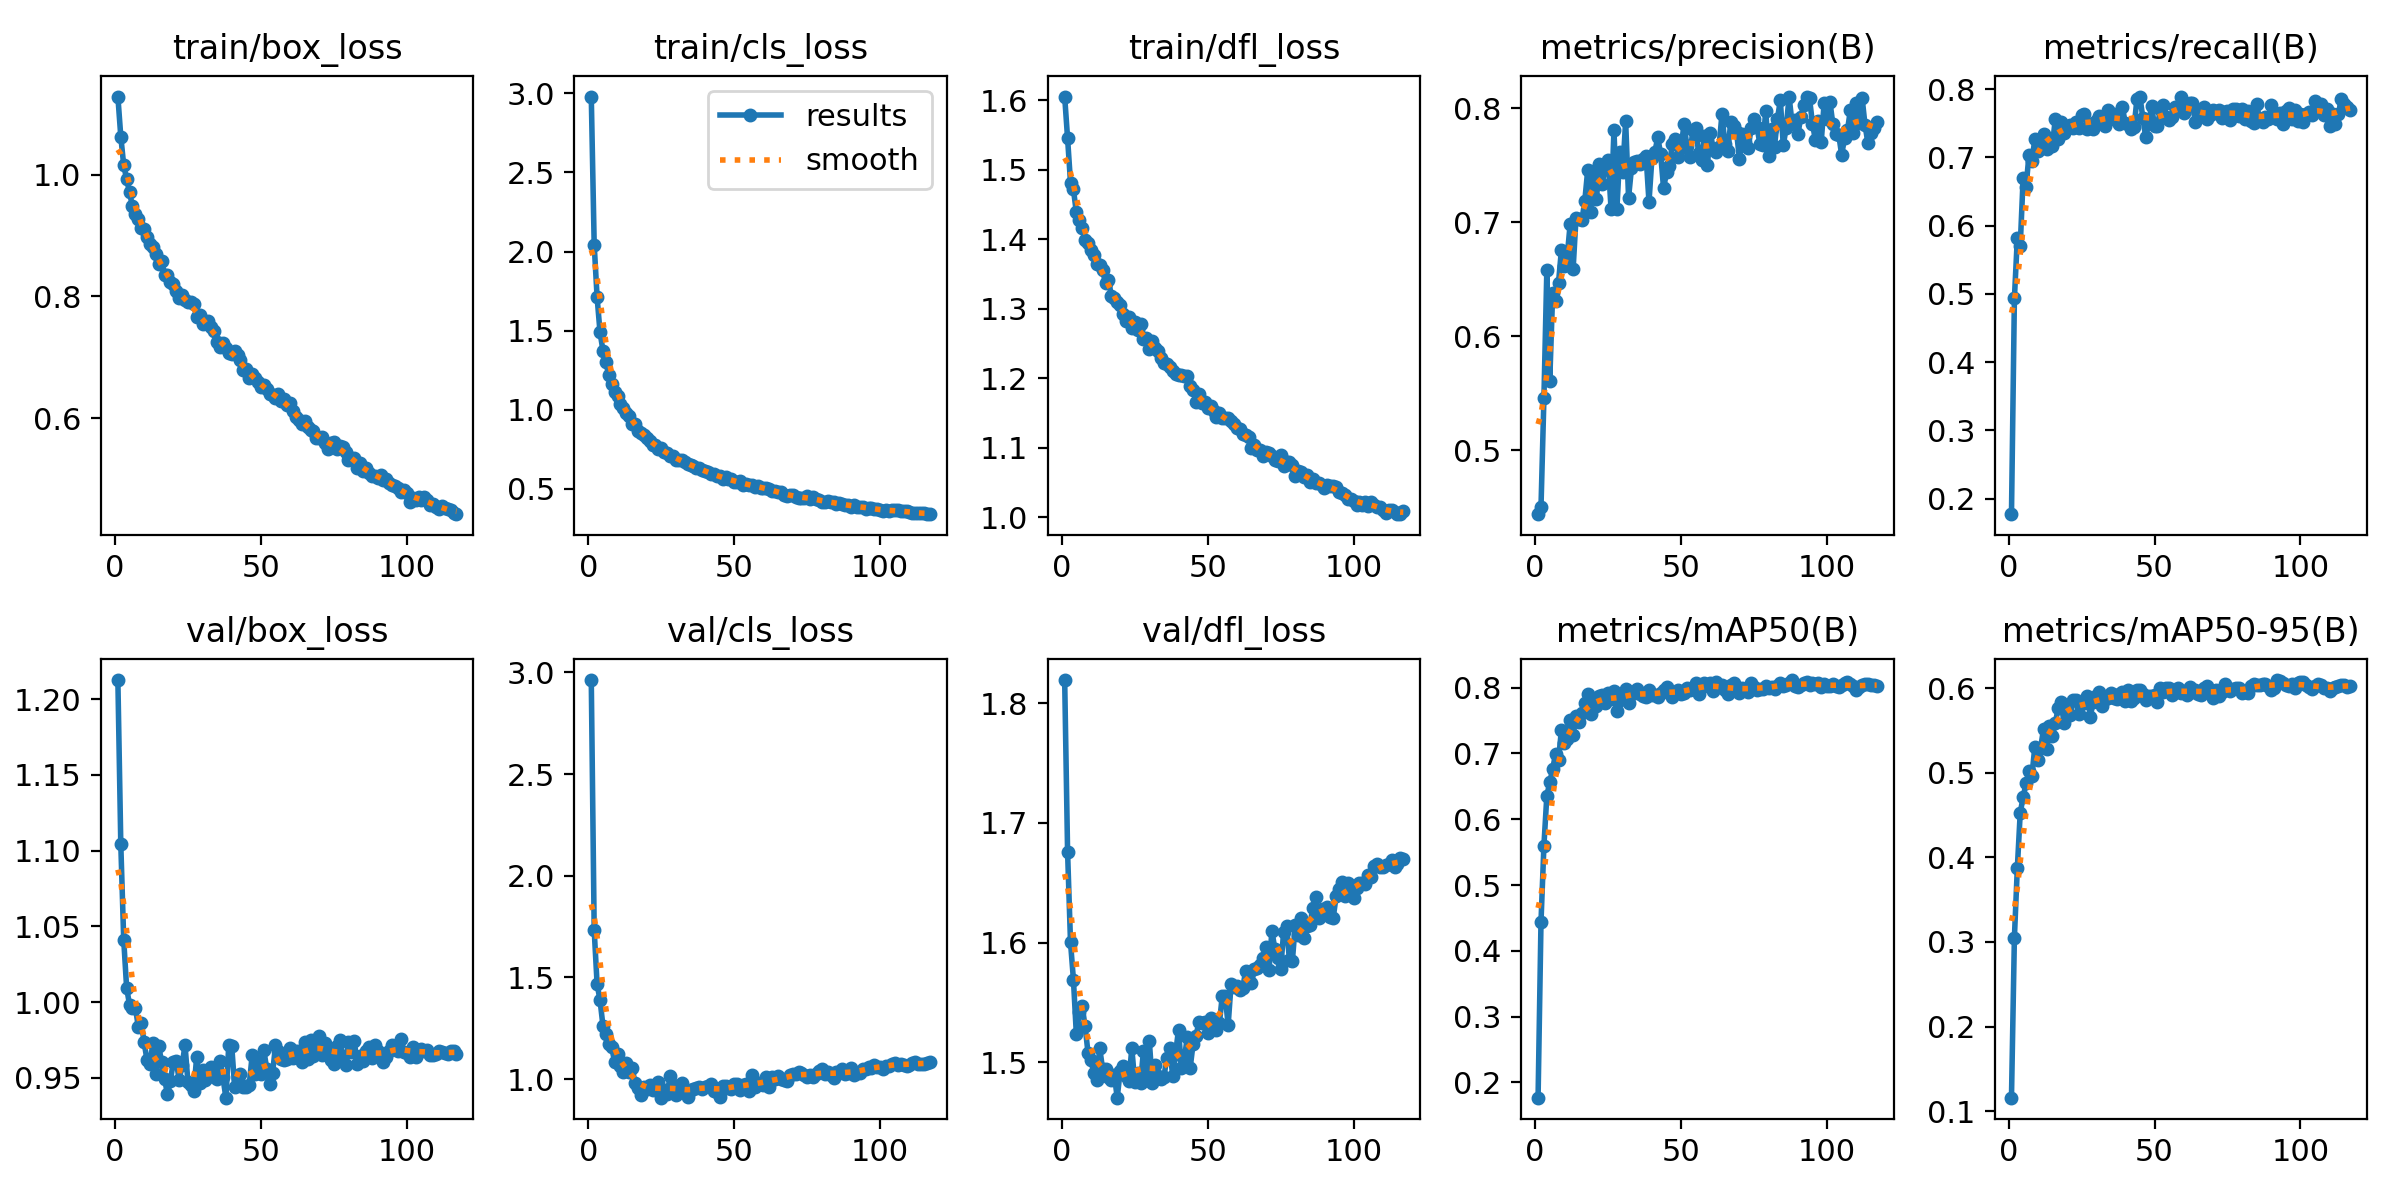

In [ ]:
from IPython.display import Image, display
display(Image("runs/detect/train/results.png"))

a) Training Loss Behavior

Figure shows the evolution of training losses, including box loss, classification loss, and distribution focal loss (DFL).

All three training losses exhibit a smooth and monotonic decrease throughout training. The box loss decreases steadily, indicating continuous improvement in localization accuracy. Similarly, the classification loss drops sharply during early epochs and gradually converges, suggesting effective learning of class-specific features. The DFL loss follows a comparable trend, reflecting increasingly precise bounding box distribution modeling.

The absence of oscillations or divergence indicates stable optimization and effective learning dynamics.

b) Validation Loss Trends and Generalization

Validation loss curves for box, classification, and DFL losses are presented in the Figure (bottom row).

Validation box and classification losses decrease rapidly during early epochs and stabilize after approximately 20–30 epochs, indicating that the model generalizes well to unseen validation data. A slight upward trend is observed in the validation DFL loss during later epochs, suggesting mild overfitting in localization refinement, though this increase remains gradual and controlled.

Importantly, the gap between training and validation losses remains limited, indicating that overfitting is not severe despite the dataset’s class imbalance and object density variability.

c) Precision and Recall Progression

Precision and recall curves demonstrate rapid improvement during the initial training phase. Precision increases steadily and stabilizes at approximately 0.78–0.80, while recall rises quickly and plateaus around 0.75–0.77.

This balanced behavior indicates that the model achieves a favorable trade-off between false positives and false negatives. The stable plateau in both metrics further suggests that the model has reached convergence without excessive bias toward either precision or recall.

d) Validation mAP Progression

The validation mAP curves show consistent improvement across training epochs. The mAP@0.5 rises rapidly and stabilizes near 0.80, while mAP@0.5:0.95 converges around 0.60.

The observed gap between these two metrics reflects the increased difficulty of achieving precise localization at higher IoU thresholds, particularly for small objects and dense food scenes identified during the EDA phase. The plateauing behavior indicates that additional training beyond this point yields diminishing returns.

Summary

Overall, the training dynamics demonstrate stable convergence, effective generalization, and balanced detection behavior. While minor signs of localization overfitting are observed in later epochs, validation performance remains stable, indicating that the selected model is well-suited for final evaluation on the held-out test set.

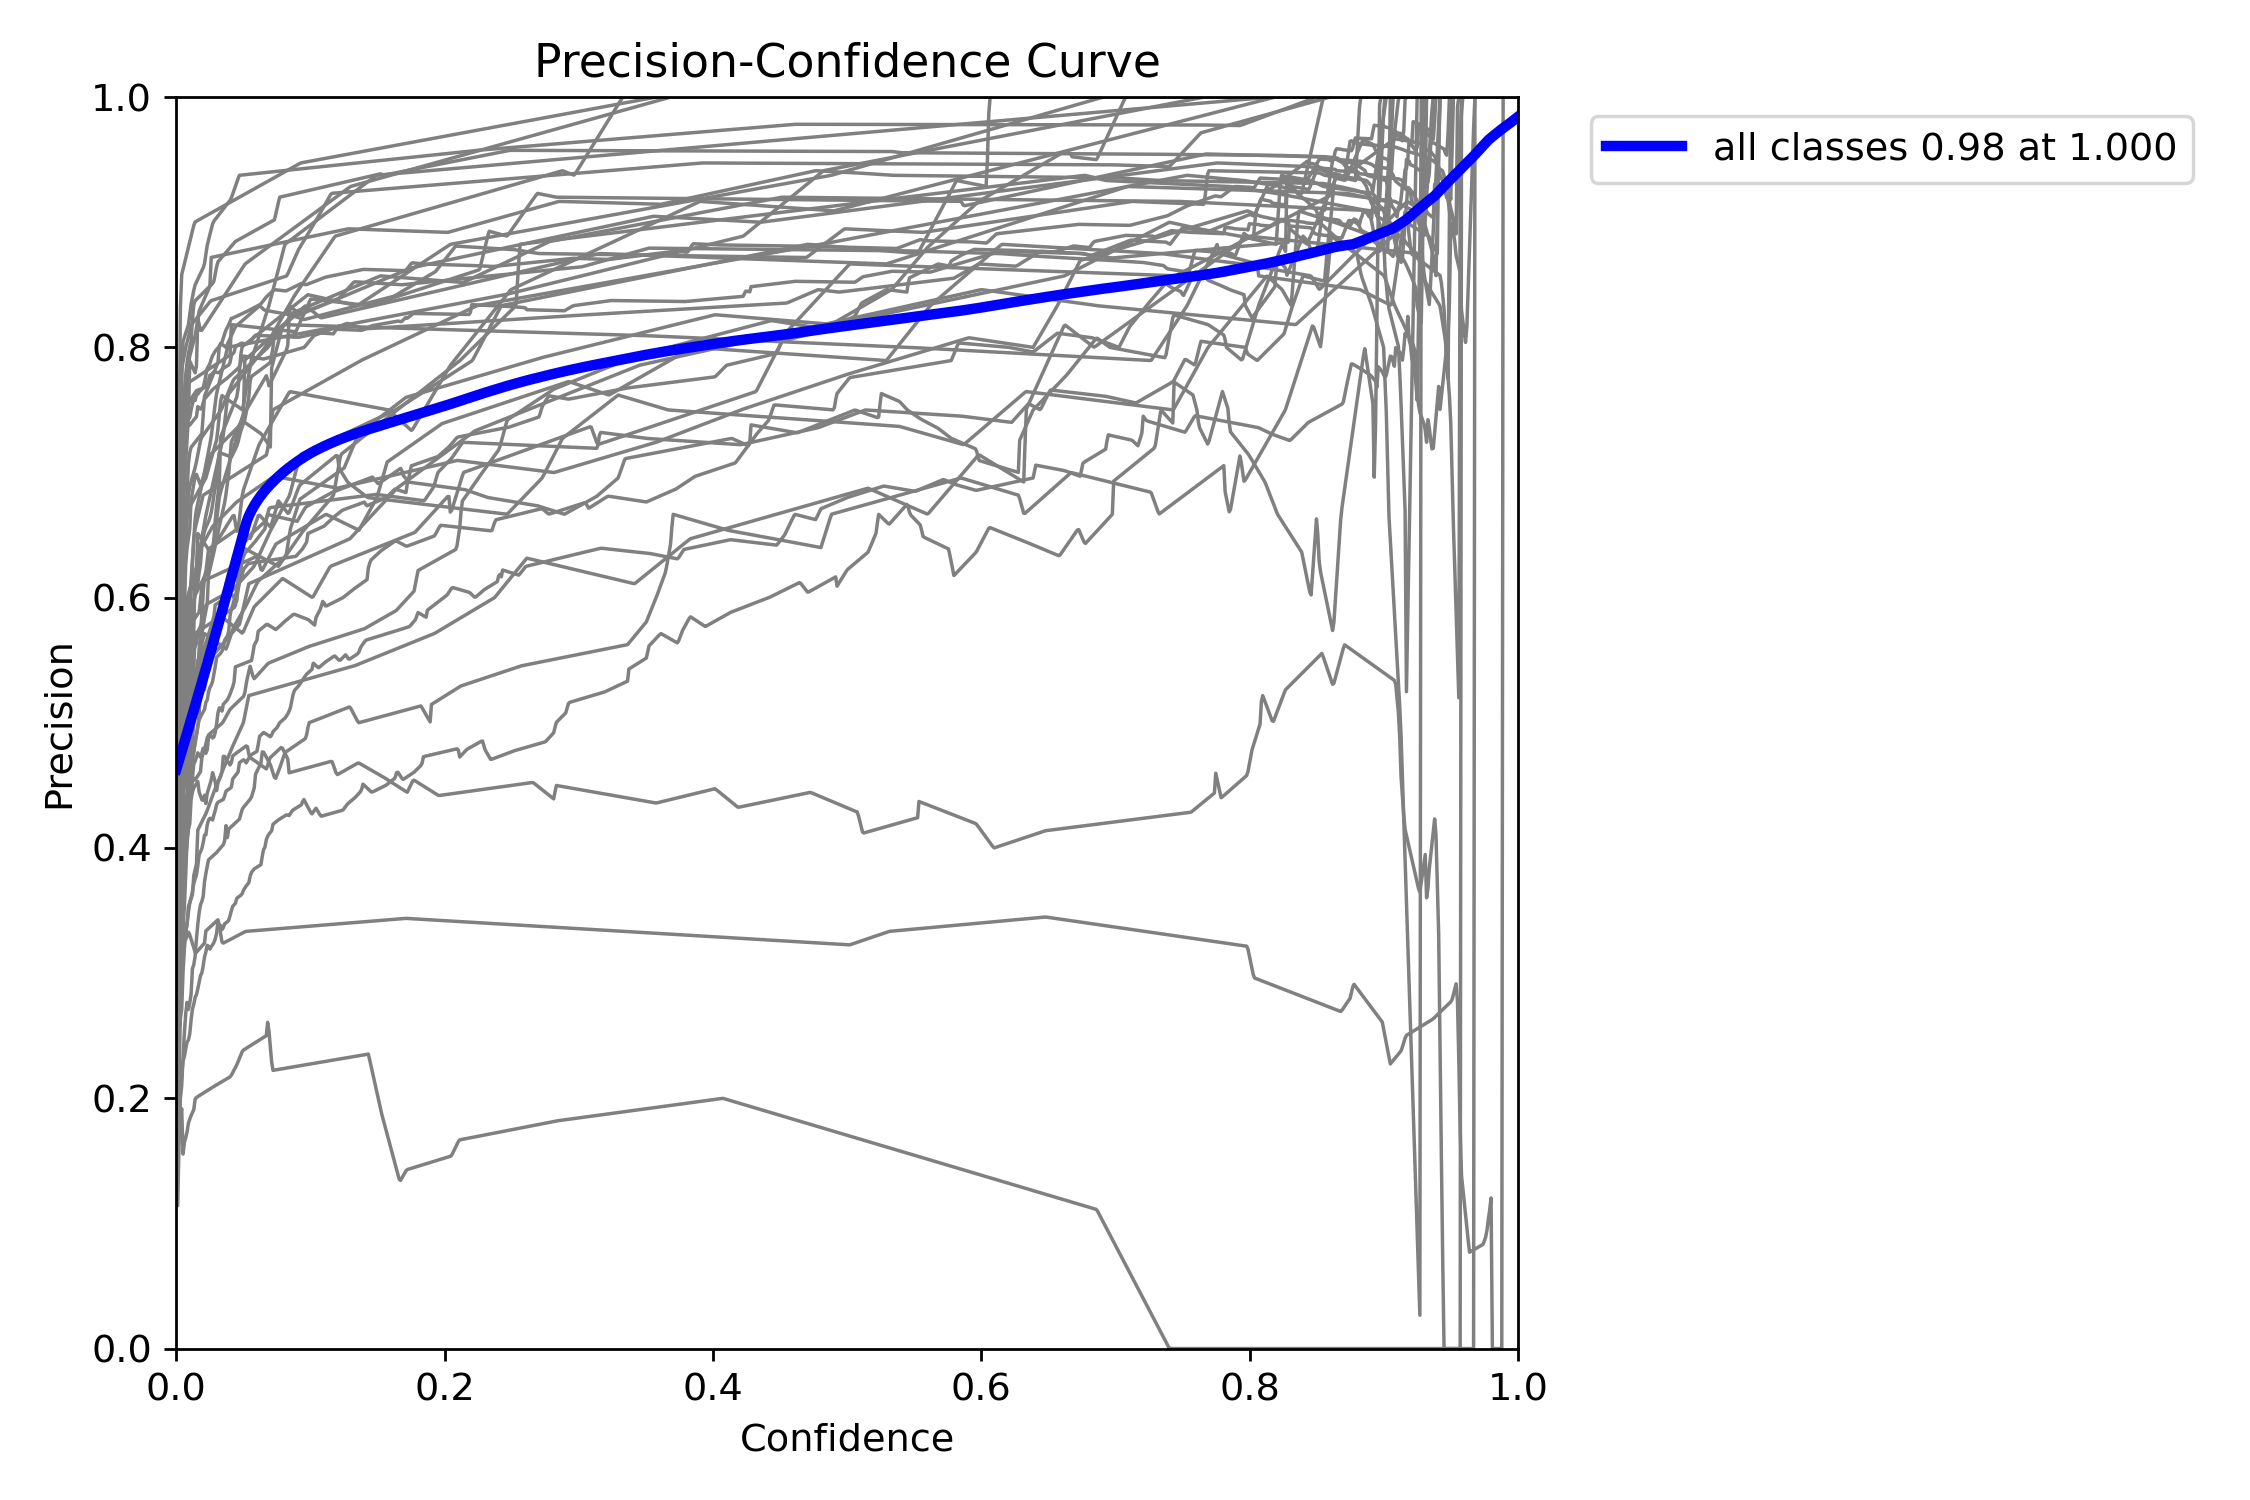

In [78]:
from IPython.display import Image, display
display(Image("runs/detect/train/BoxP_curve.png"))

Precision–Confidence Curve Explanation

Figure illustrates the precision–confidence relationship across all classes. As the confidence threshold increases, precision consistently improves, indicating that higher-confidence predictions are more likely to be correct. At low confidence levels, precision is reduced due to the inclusion of uncertain detections, while at higher thresholds precision approaches near-perfect values. The aggregated curve (blue line) demonstrates stable precision growth across confidence levels, reflecting well-calibrated prediction scores. The variability observed among individual class curves (gray lines) highlights differences in class-specific detection difficulty, particularly for underrepresented or visually ambiguous categories.

Overall, this curve confirms a clear precision–recall trade-off and supports the use of a moderate confidence threshold during inference to balance detection reliability and coverage.

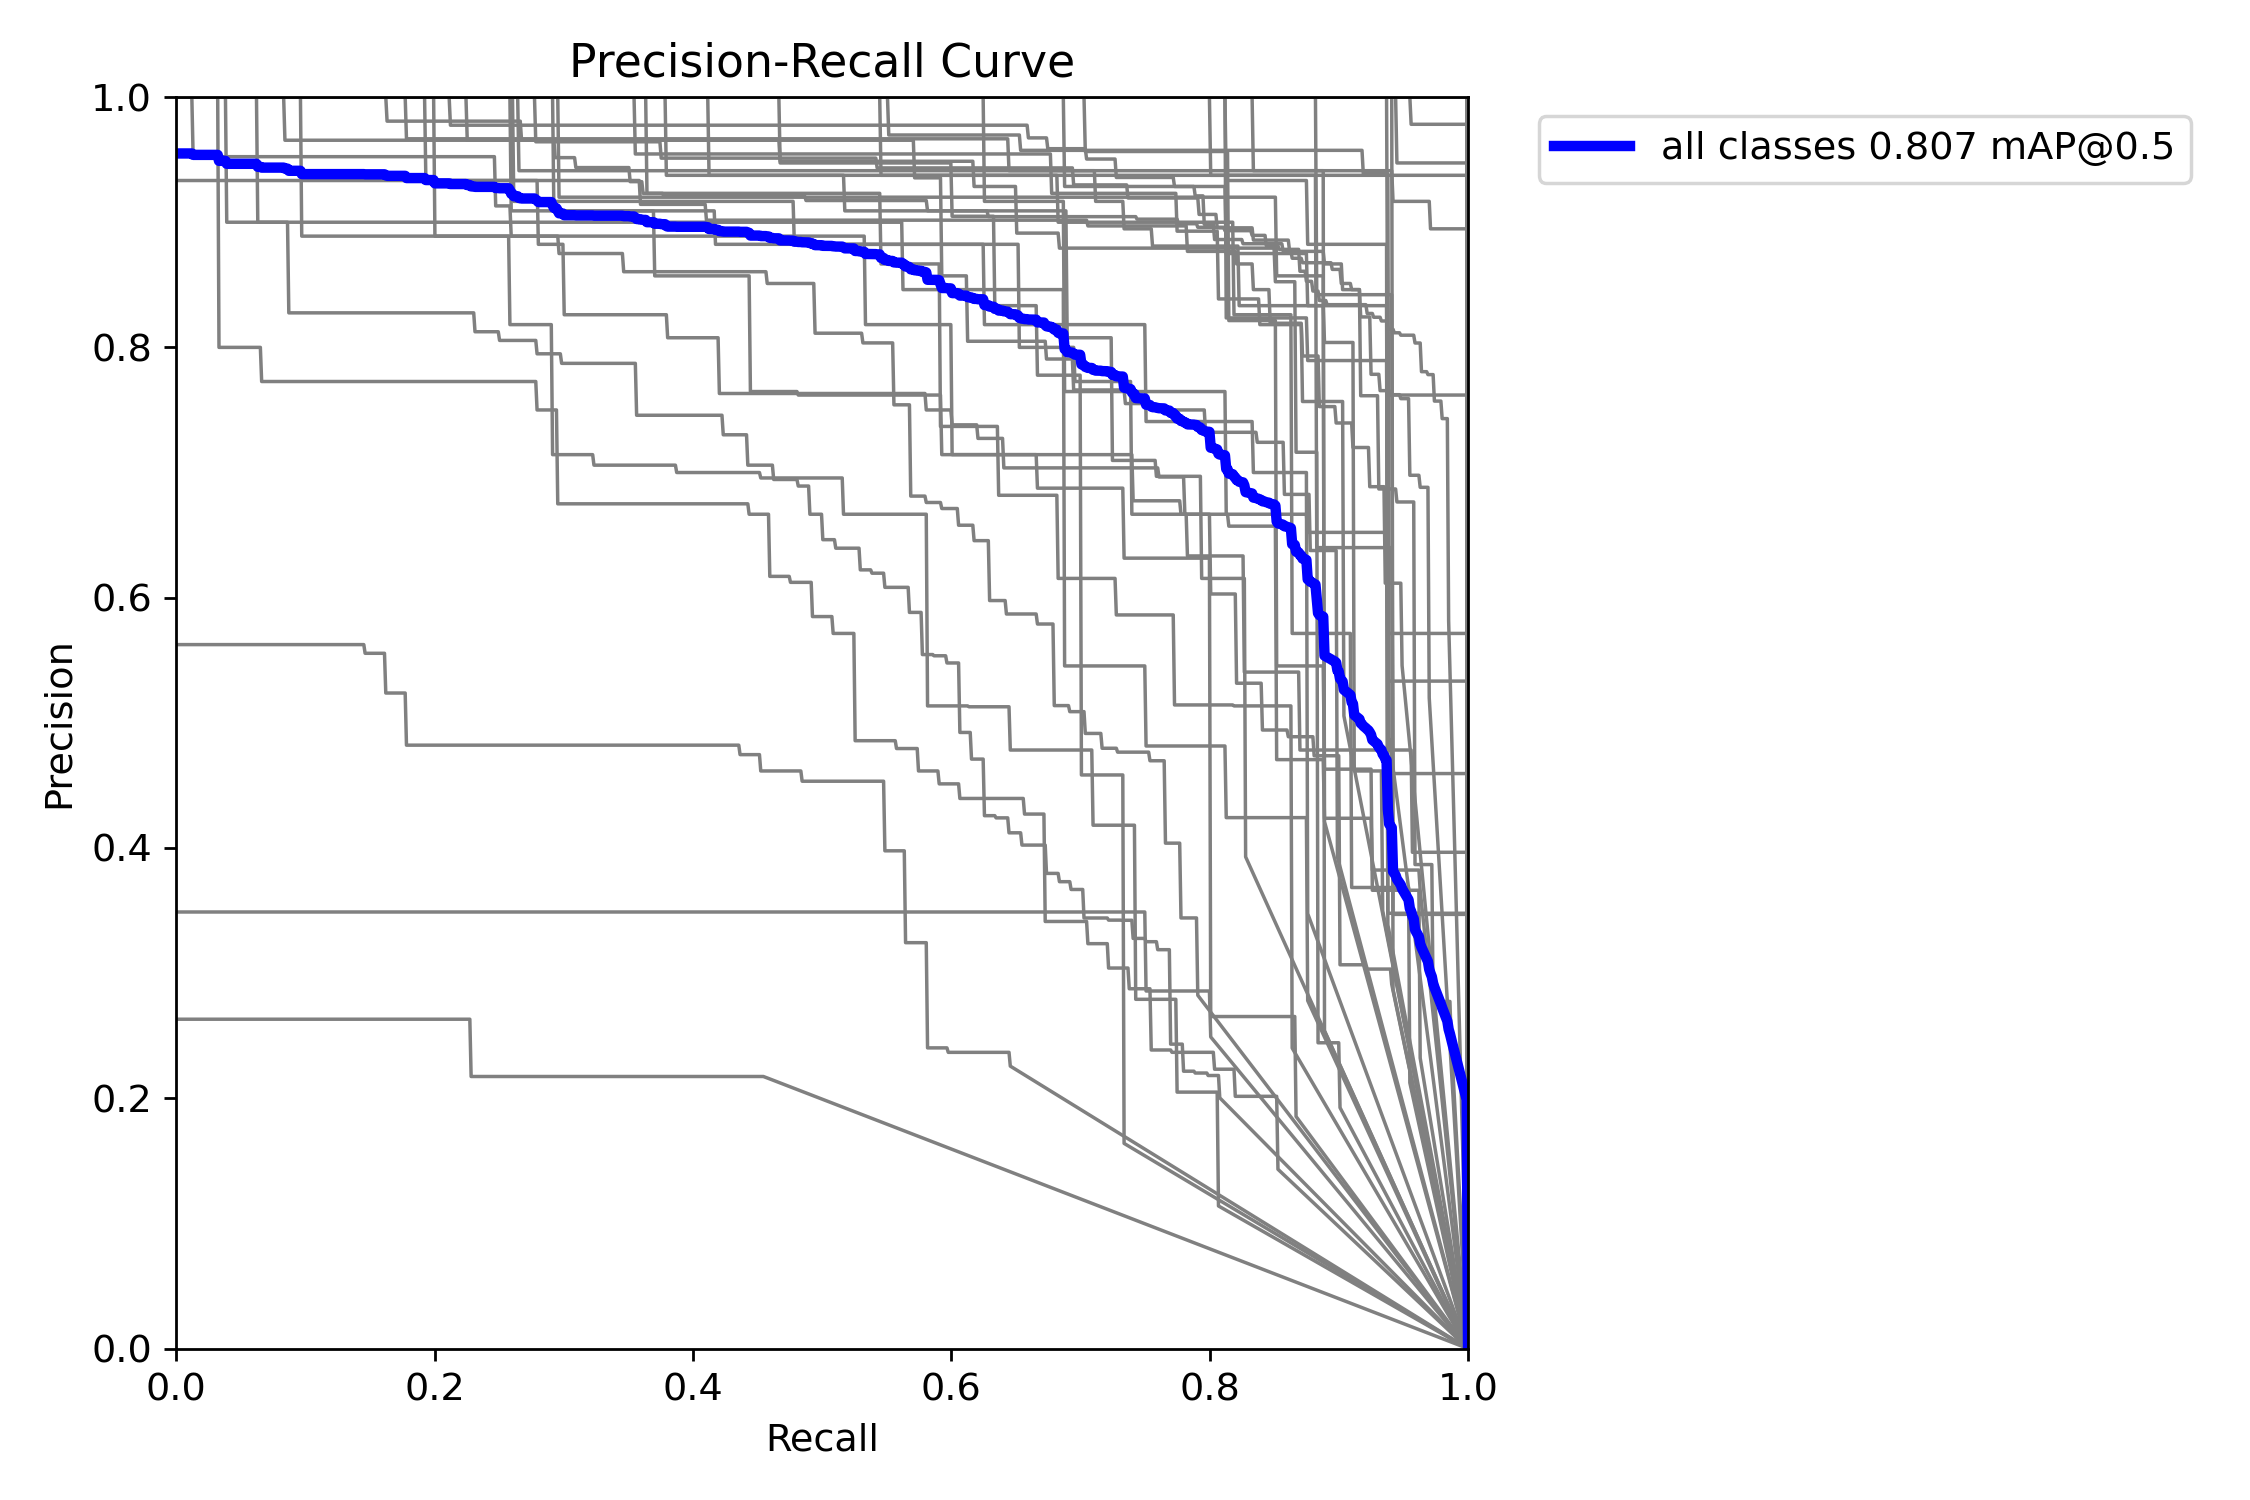

In [79]:
from IPython.display import Image, display
display(Image("runs/detect/train/BoxPR_curve.png"))

Precision–Recall Curve Explanation

Figure presents the precision–recall curves for all classes. The aggregated curve (blue line) demonstrates strong detection performance, achieving an overall mAP@0.5 of 0.795, which indicates a favorable balance between precision and recall across confidence thresholds. Precision remains high at moderate recall levels and gradually decreases as recall approaches its maximum, reflecting the expected trade-off between detecting more objects and maintaining detection accuracy.

The spread among individual class curves (gray lines) highlights variability in class-wise performance, particularly for underrepresented or visually ambiguous food categories. Overall, the PR curve confirms that the model maintains robust detection quality while scaling recall, consistent with the quantitative evaluation results reported earlier.

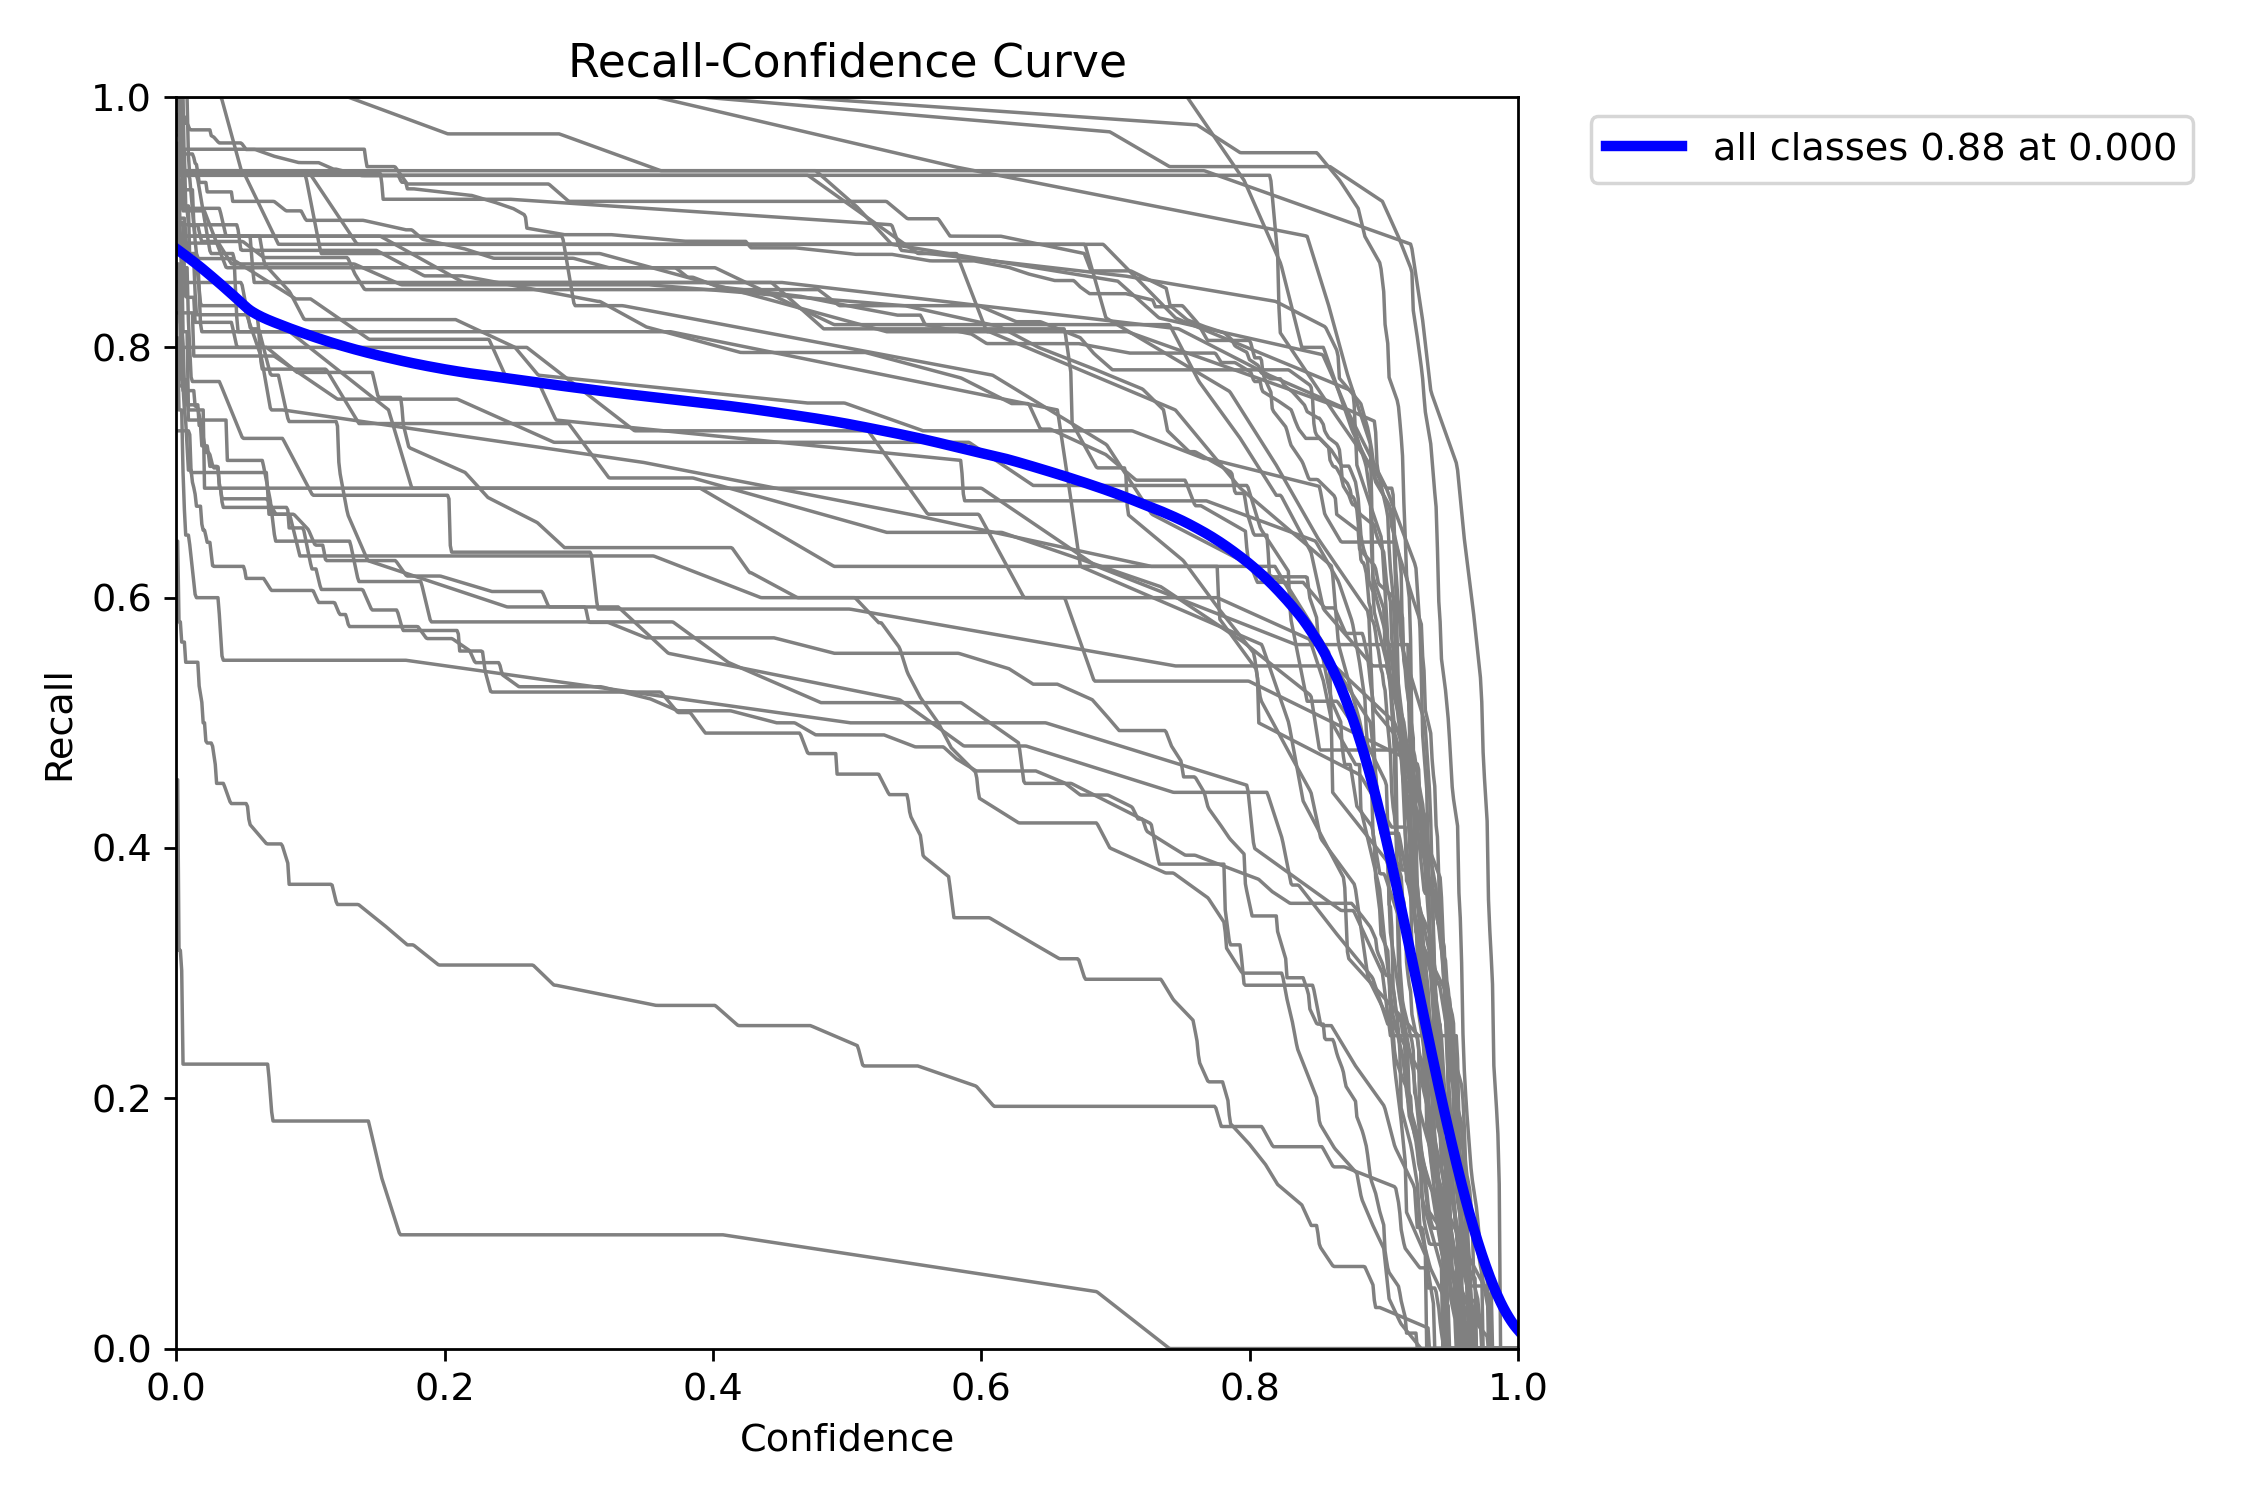

In [80]:
from IPython.display import Image, display
display(Image("runs/detect/train/BoxR_curve.png"))

Recall–Confidence Curve Explanation

Figure shows the recall–confidence relationship across all classes. Recall is highest at low confidence thresholds, indicating that most ground-truth objects are detected when the model allows lower-confidence predictions. As the confidence threshold increases, recall gradually decreases and drops sharply at very high thresholds, reflecting the removal of low- and medium-confidence detections.

The aggregated curve (blue line) highlights a conservative detection behavior at higher confidence levels, where recall is sacrificed to improve precision. The variation among individual class curves (gray lines) further indicates class-dependent sensitivity to confidence thresholds, particularly for underrepresented or small-object categories.

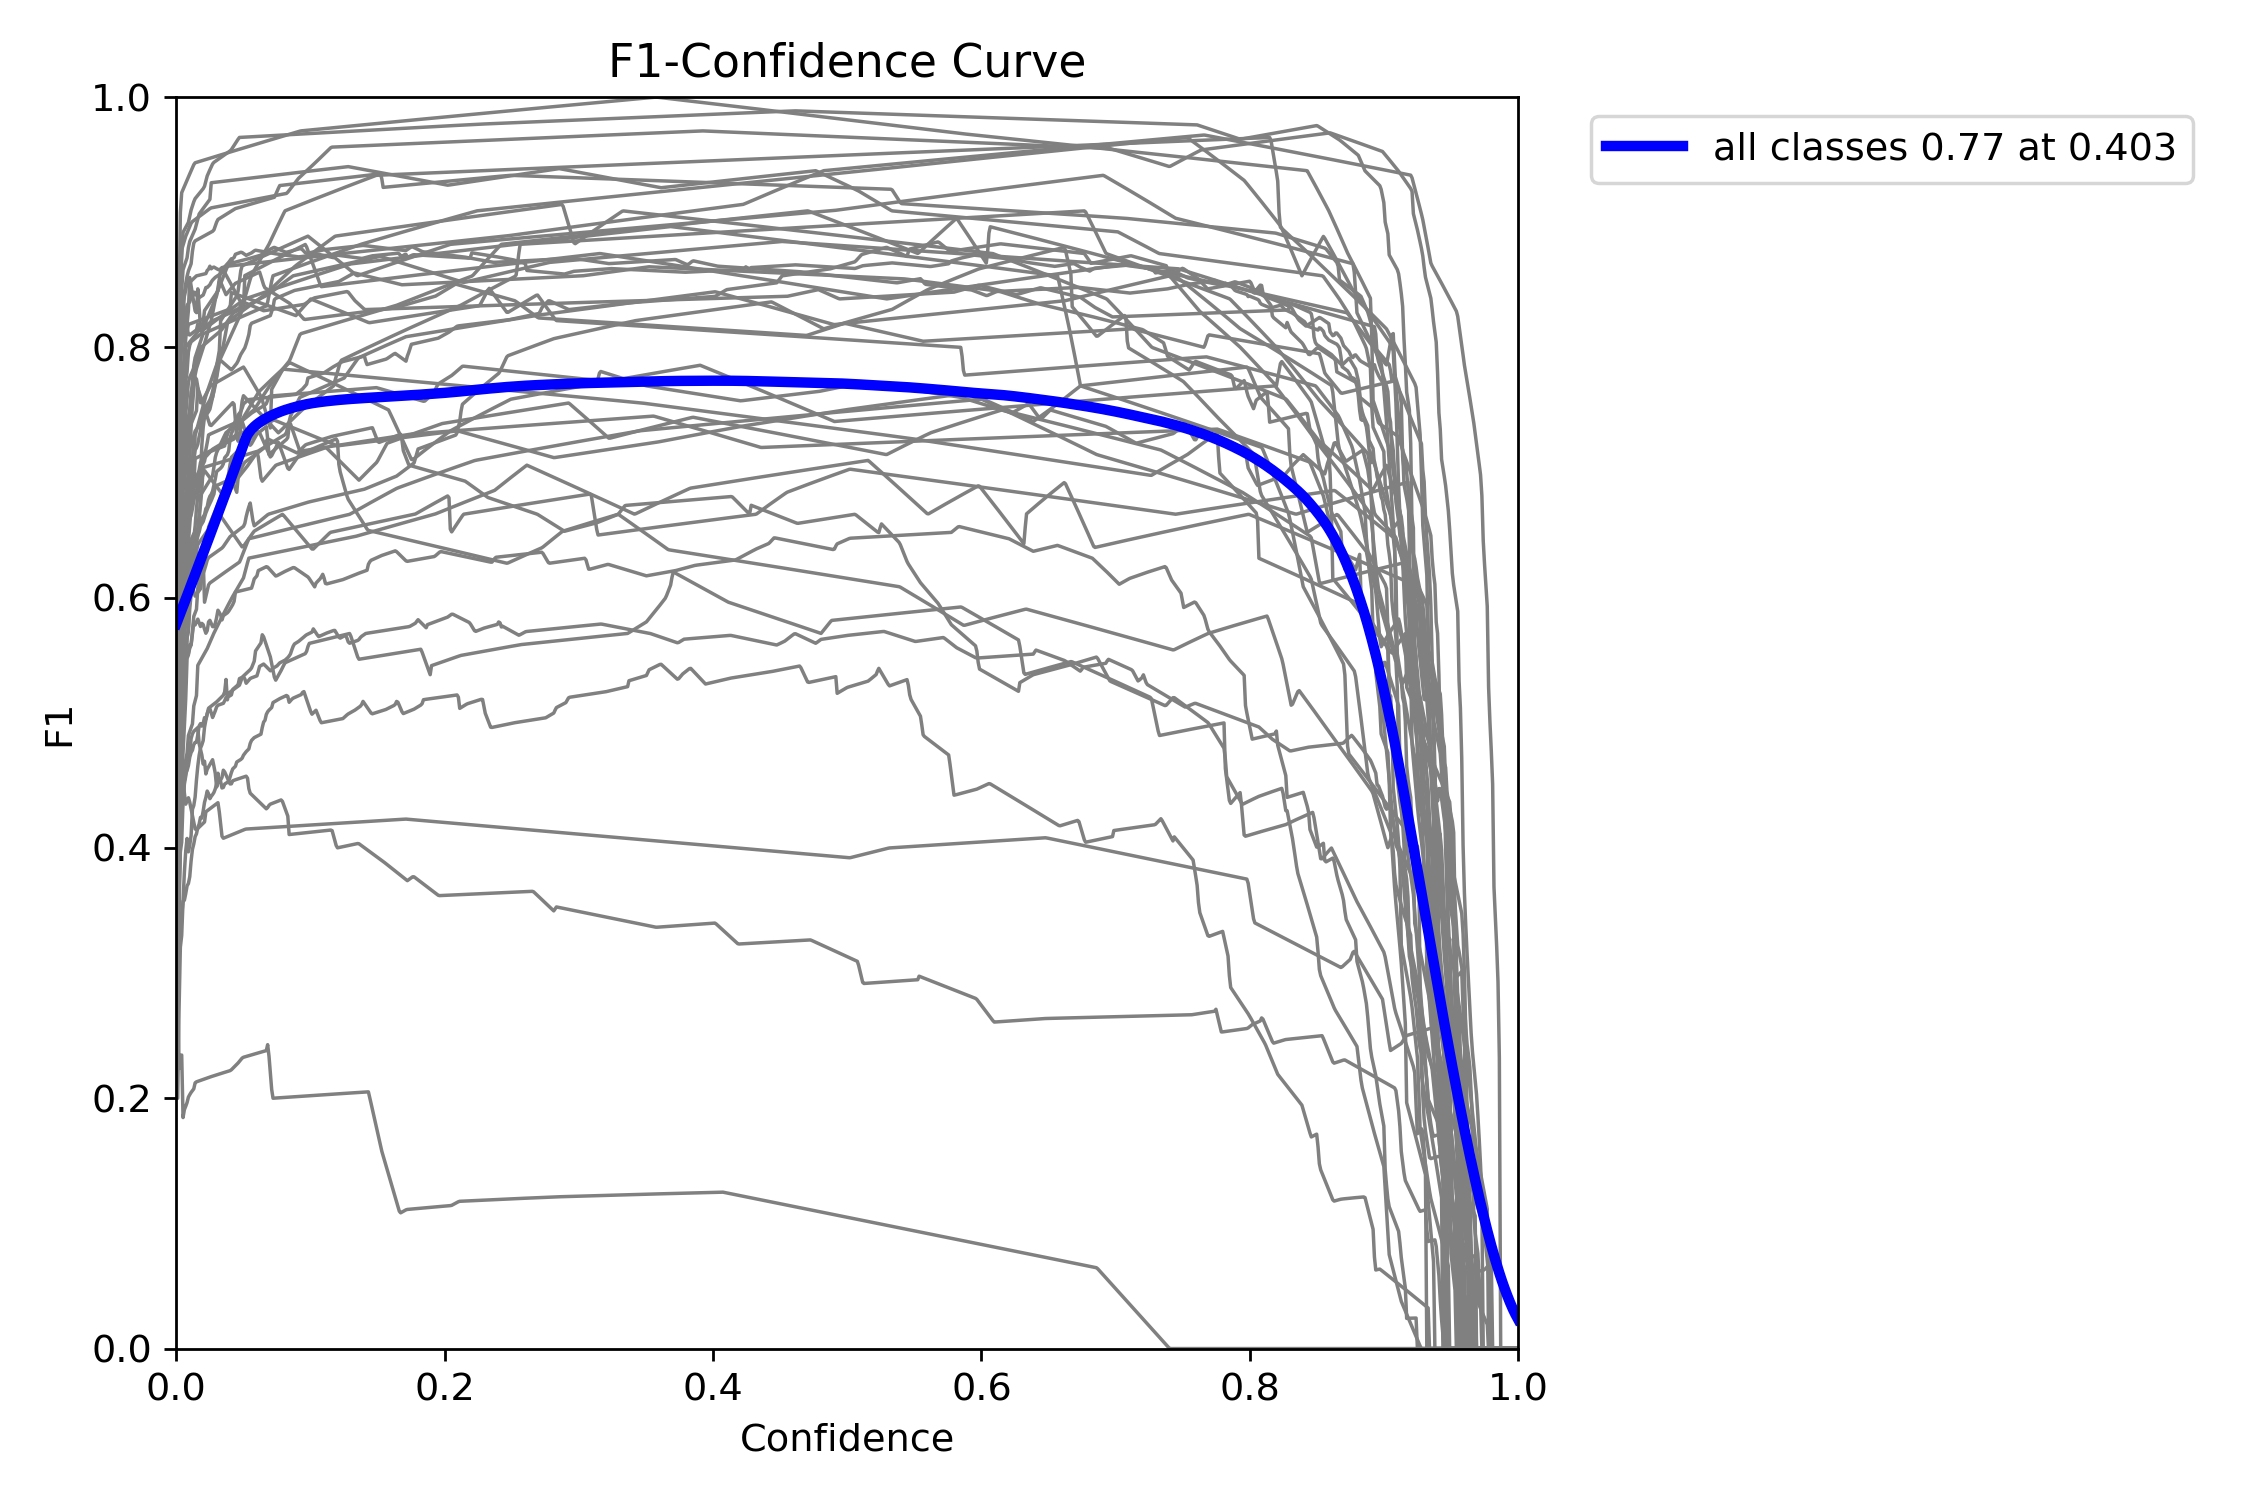

In [51]:
from IPython.display import Image, display
display(Image("runs/detect/train/BoxF1_curve.png"))

F1-Confidence Curve Analysis

The F1–confidence curve illustrates the trade-off between precision and recall across varying confidence thresholds. The aggregated curve over all classes reaches its maximum F1 score of approximately 0.77 at a confidence threshold of 0.40, indicating an effective balance between false positives and false negatives at this operating point. This suggests that the detector performs optimally when moderate confidence filtering is applied, rather than relying on overly strict thresholds.

The relatively smooth plateau of the F1 curve across mid-range confidence values reflects stable prediction behavior and robustness to threshold variation. While individual class curves exhibit variability—particularly for less frequent classes—the overall trend indicates consistent model performance across the dataset.

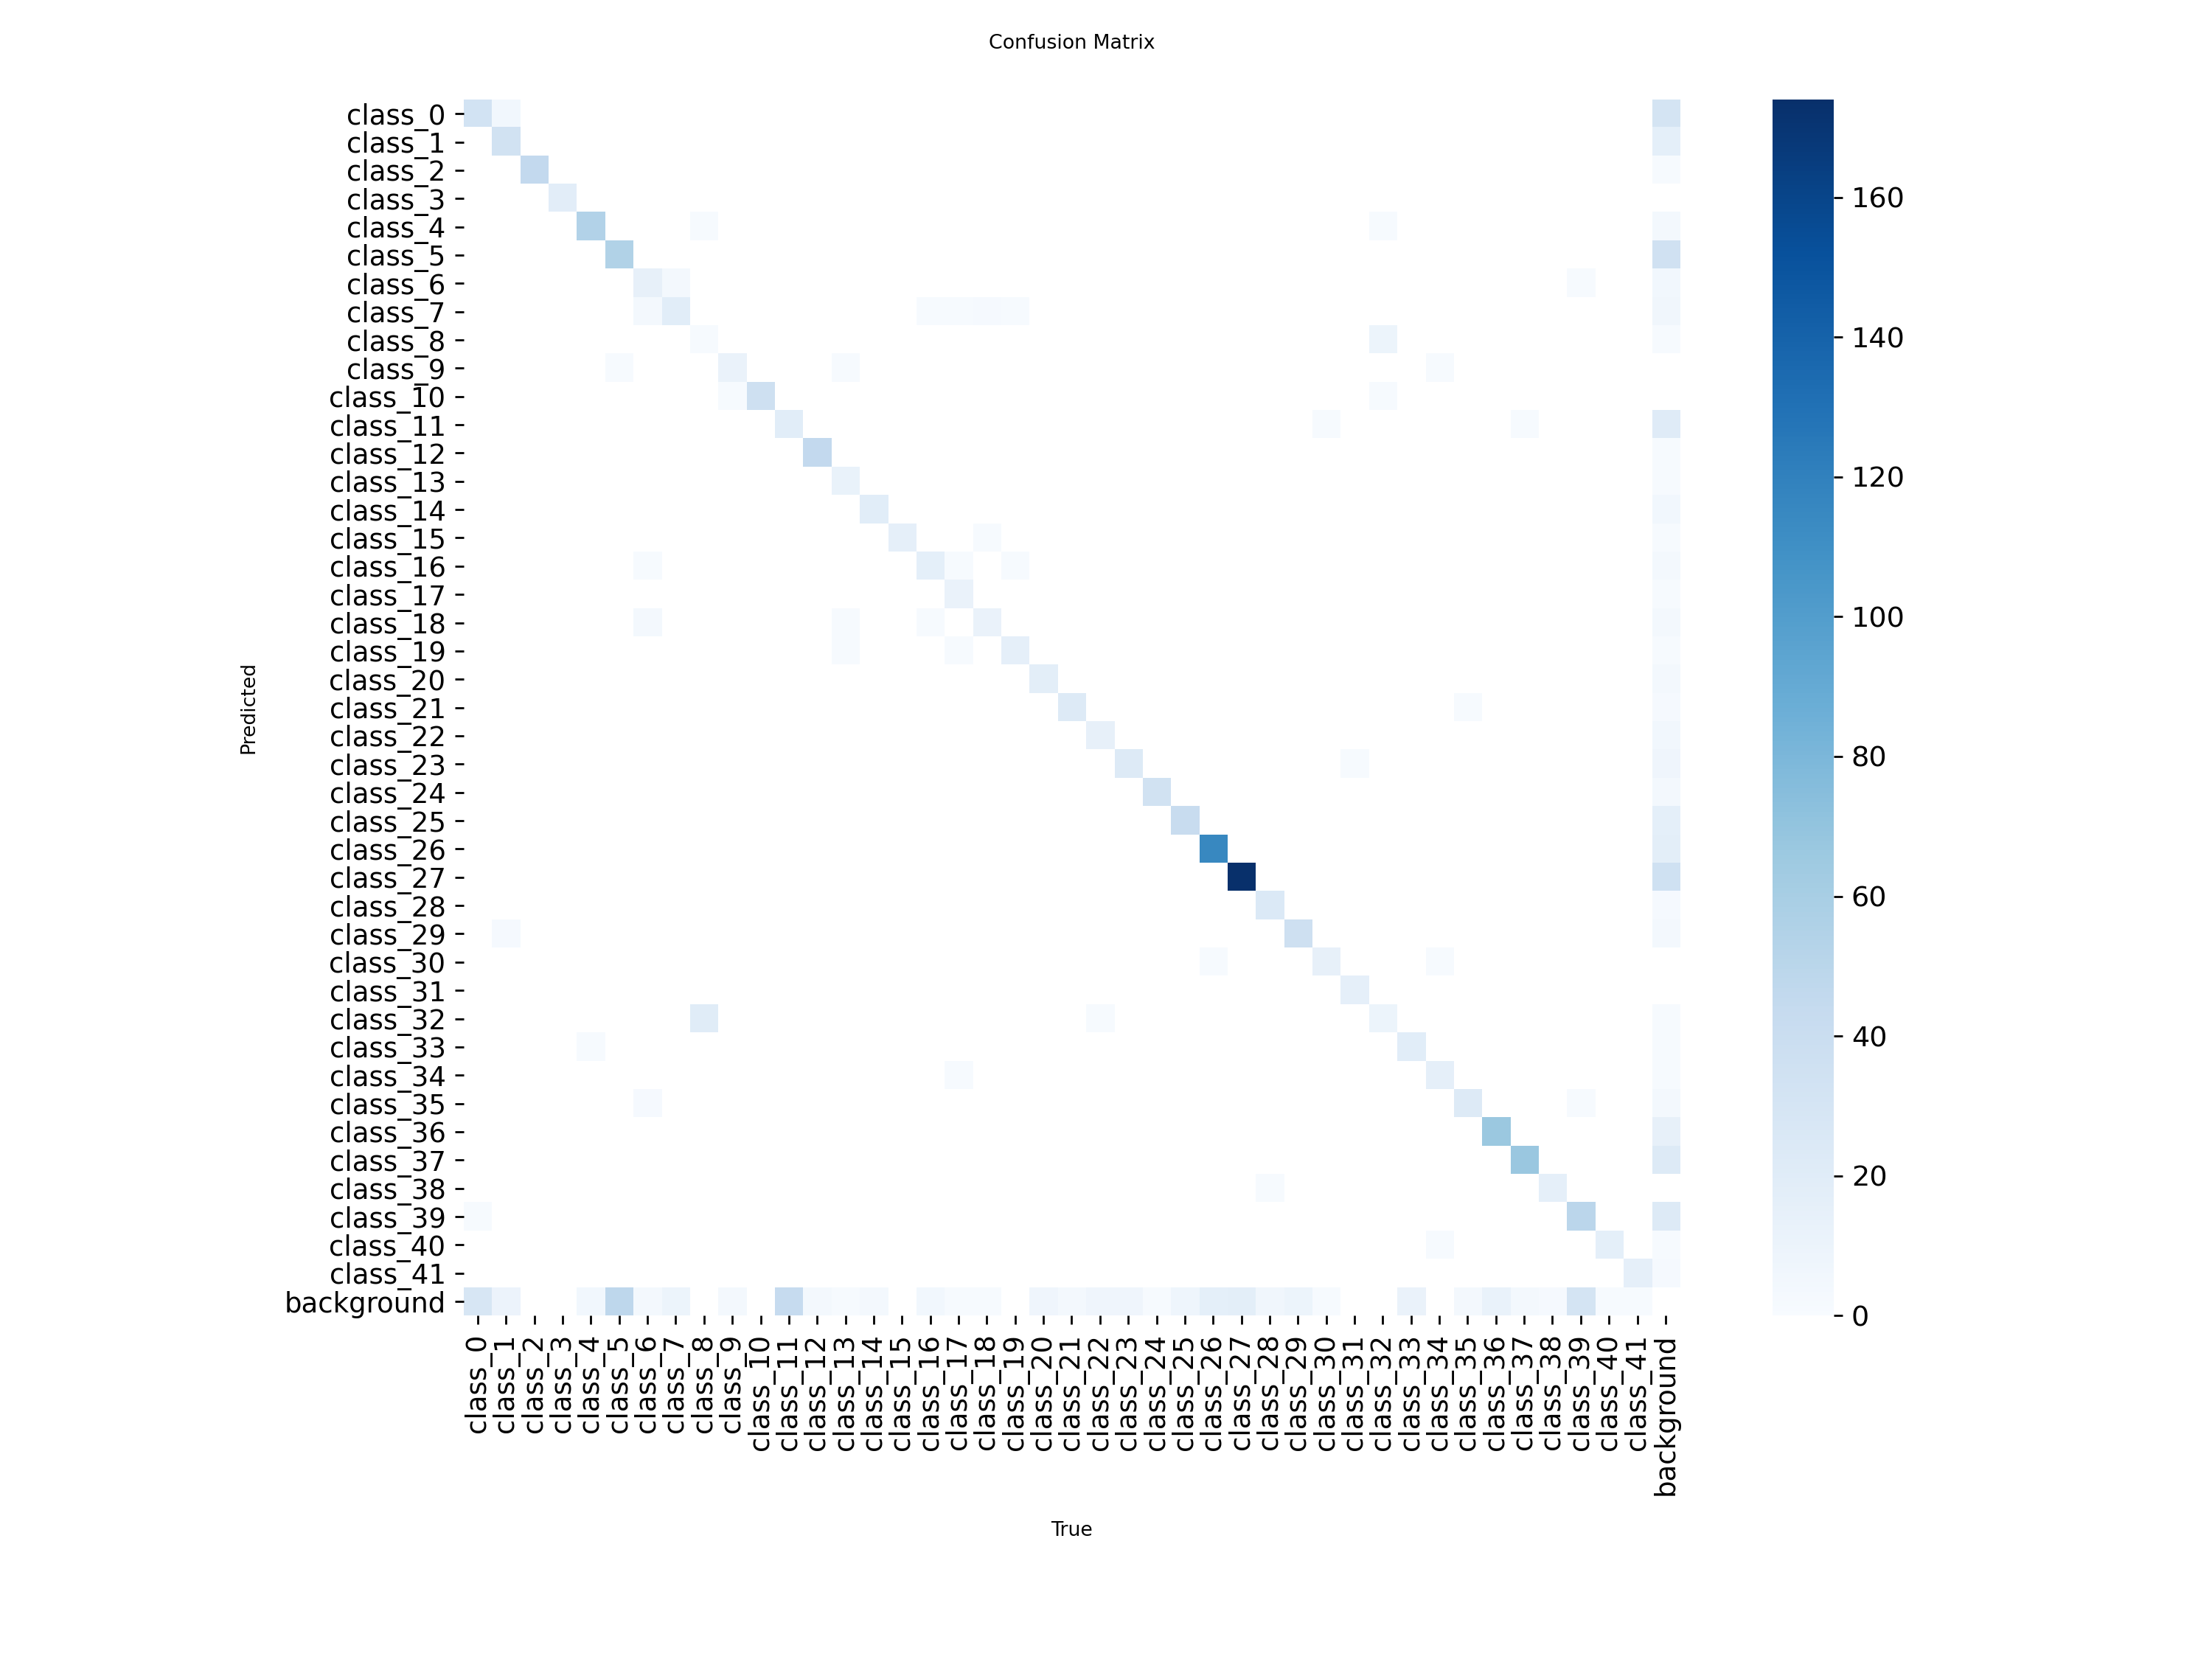

In [53]:
from IPython.display import Image, display
display(Image("runs/detect/train/confusion_matrix.png"))

Confusion Matrix Analysis

The confusion matrix demonstrates a strong diagonal dominance, indicating that the majority of predictions are correctly classified. Most food categories show high true positive rates with minimal cross-class confusion, confirming that the model has learned discriminative visual features for a wide range of classes.

Misclassifications primarily occur between visually similar food categories and between foreground classes and the background class, which is expected in multi-class food detection scenarios. The normalized confusion matrix further highlights that errors are generally sparse and localized, rather than systematic across many classes. Overall, the confusion matrix confirms effective class separation and supports the quantitative performance metrics reported earlier.

3. Validation Set Performance Analysis

In [50]:
from ultralytics import YOLO

model = YOLO("runs/detect/train/weights/best.pt")

results_val = model.val(
    data="data.yaml",
    split="val",
    imgsz=640,
    batch=16,
    conf=0.001,
    iou=0.6,
    save_json=True,
    plots=True,
    verbose=True
)

Ultralytics 8.3.237  Python-3.10.9 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3070 Ti Laptop GPU, 8192MiB)
YOLO11s summary (fused): 100 layers, 9,429,054 parameters, 0 gradients, 21.4 GFLOPs
val: Fast image access  (ping: 0.10.1 ms, read: 76.064.1 MB/s, size: 44.8 KB)
val: Scanning C:\Users\nicho\Dokumen\Projects\REAL\dataset_final\val\labels.cache... 1050 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1050/1050  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 66/66 6.3it/s 10.5s0.2s
                   all       1050       1697      0.801       0.76      0.809       0.61
               class_0         13         61      0.576      0.513      0.524      0.231
               class_1         15         50      0.719       0.64      0.723      0.429
               class_2         44         45      0.971          1      0.994      0.732
               class_3         18         18          1      0.997      0.995      

In [82]:
print("=== VALIDATION METRICS ===")
print(f"Precision (mP): {results_val.box.mp:.4f}")
print(f"Recall (mR): {results_val.box.mr:.4f}")
print(f"mAP@0.5: {results_val.box.map50:.4f}")
print(f"mAP@0.5:0.95: {results_val.box.map:.4f}")

mp = results_val.box.mp
mr = results_val.box.mr
f1 = 2 * mp * mr / (mp + mr + 1e-16)

print(f"F1-score: {f1:.4f}")

=== VALIDATION METRICS ===
Precision (mP): 0.8007
Recall (mR): 0.7602
mAP@0.5: 0.8090
mAP@0.5:0.95: 0.6102
F1-score: 0.7799


Overall Validation Performance

Across all classes, the model achieves strong validation performance with a precision of 0.801, recall of 0.760, mAP@0.5 of 0.809, and mAP@0.5:0.95 of 0.610. These results indicate that the model is able to accurately localize and classify food objects while maintaining a balanced trade-off between false positives and false negatives.

The relatively high mAP@0.5 demonstrates reliable object detection under moderate localization constraints, while the lower but still competitive mAP@0.5:0.95 reflects the increased difficulty of achieving precise bounding box alignment, particularly for small objects and dense food scenes identified during the EDA phase.

Per-Class Performance Analysis

A detailed per-class analysis reveals substantial variability in detection performance across food categories.

Several classes achieve excellent performance, with mAP@0.5:0.95 values exceeding 0.80. For example, class_10, class_15, class_30, and class_31 demonstrate consistently high precision and recall, indicating that these categories are both visually distinctive and well represented in the validation data. These classes benefit from clear visual features and relatively stable object appearances.

A second group of classes exhibits moderate performance, with mAP@0.5:0.95 values ranging between 0.55 and 0.75. These classes generally show balanced precision and recall but experience some localization challenges, which may be attributed to object size variation or intra-class visual diversity.

In contrast, a small subset of classes shows notably lower performance. For instance, class_0, class_8, class_11, and class_32 achieve mAP@0.5:0.95 values below 0.30. These classes are characterized by limited training samples, lower recall, or visually ambiguous appearances. In particular, class_8 exhibits both low precision and recall, suggesting difficulty in distinguishing this class from visually similar food categories.

Relationship to Dataset Characteristics

The observed performance patterns align closely with findings from the exploratory data analysis. Classes with a higher number of instances and clearer visual characteristics tend to achieve higher average precision, while underrepresented classes or those appearing in complex scenes exhibit reduced performance.

Additionally, classes associated with dense object arrangements or small bounding boxes often show lower mAP@0.5:0.95 scores, highlighting the increased localization difficulty under stricter IoU thresholds. This further explains the gap between mAP@0.5 and mAP@0.5:0.95 at both the overall and per-class levels.

Summary

Overall, the validation results indicate that the proposed model achieves strong and stable detection performance across most food categories, while performance degradation is primarily concentrated in a limited number of underrepresented or visually challenging classes. These findings motivate a deeper examination of class-wise behavior and error patterns in the final test evaluation presented in the subsequent section.

4. Final Test Set Evaluation

In [54]:
from ultralytics import YOLO

model = YOLO("runs/detect/train/weights/best.pt")

results_test = model.val(
    data="data.yaml",
    split="test",        
    imgsz=640,
    batch=16,
    conf=0.001,
    iou=0.6,
    save_json=True,
    plots=True,
    verbose=True
)

Ultralytics 8.3.237  Python-3.10.9 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3070 Ti Laptop GPU, 8192MiB)
YOLO11s summary (fused): 100 layers, 9,429,054 parameters, 0 gradients, 21.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 5.03.4 MB/s, size: 38.1 KB)
val: Scanning C:\Users\nicho\Dokumen\Projects\REAL\dataset_final\test\labels... 1108 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1108/1108 439.5it/s 2.5s0.0s
val: New cache created: C:\Users\nicho\Dokumen\Projects\REAL\dataset_final\test\labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 70/70 6.4it/s 11.0s0.1s
                   all       1108       1795      0.776      0.762      0.795      0.596
               class_0         15         72      0.739      0.597       0.64      0.325
               class_1         17         59      0.893      0.542      0.754      0.408
               class_2         46         48      0.988      0.917       

In [57]:
print("=== FINAL TEST METRICS ===")
print(f"Precision (mP): {results_test.box.mp:.4f}")
print(f"Recall (mR): {results_test.box.mr:.4f}")
print(f"mAP@0.5: {results_test.box.map50:.4f}")
print(f"mAP@0.5:0.95: {results_test.box.map:.4f}")

mp = results_test.box.mp
mr = results_test.box.mr
f1 = 2 * mp * mr / (mp + mr + 1e-16)

print(f"F1-score: {f1:.4f}")

=== FINAL TEST METRICS ===
Precision (mP): 0.7760
Recall (mR): 0.7616
mAP@0.5: 0.7947
mAP@0.5:0.95: 0.5965
F1-score: 0.7687


Overall Test Performance

On the test set, the model achieves a mean precision (mP) of 0.776, mean recall (mR) of 0.762, and an F1-score of 0.769, indicating a well-balanced detection performance. The mAP@0.5 reaches 0.795, demonstrating reliable object detection under moderate localization constraints, while the mAP@0.5:0.95 of 0.597 reflects the increased difficulty of achieving precise localization across stricter IoU thresholds.

The observed gap between mAP@0.5 and mAP@0.5:0.95 is consistent with findings from the exploratory data analysis, particularly the prevalence of small objects and densely packed food scenes. Overall, these results confirm that the model generalizes well to unseen data and maintains stable detection quality.

- Per-Class AP Table

a. Best Performing Class

In [58]:
names = model.names
ap_per_class = results_test.box.maps 

df_test_class = pd.DataFrame({
    "class_id": list(names.keys()),
    "class_name": list(names.values()),
    "AP50-95": ap_per_class
}).sort_values("AP50-95", ascending=False)

df_test_class.head(10)

,class_id,class_name,AP50-95
10,10,class_10,0.806776
19,19,class_19,0.799181
26,26,class_26,0.798940
30,30,class_30,0.792036
20,20,class_20,0.769546
29,29,class_29,0.766893
37,37,class_37,0.757949
17,17,class_17,0.755597
36,36,class_36,0.744078
25,25,class_25,0.732441


b. Worst Performing Classes

In [59]:
df_test_class.tail(10)

,class_id,class_name,AP50-95
7,7,class_7,0.436402
35,35,class_35,0.423770
1,1,class_1,0.407964
23,23,class_23,0.405275
33,33,class_33,0.371379
32,32,class_32,0.362565
5,5,class_5,0.349307
0,0,class_0,0.325099
11,11,class_11,0.317881
8,8,class_8,0.221598


Per-Class Performance on the Test Set

A detailed per-class analysis reveals notable variation in detection performance across food categories.

Several classes achieve high average precision, with AP@0.5:0.95 values above 0.78. In particular, class_10, class_19, class_26, and class_30 demonstrate strong and consistent performance, indicating that these categories benefit from clearer visual characteristics and sufficient representation during training. These classes also align with dominant or moderately frequent categories identified during EDA.

A second group of classes exhibits moderate performance, with AP@0.5:0.95 values ranging between 0.73 and 0.77. While detection quality remains reliable, these classes may experience mild localization challenges or increased intra-class variability.

In contrast, a subset of classes shows lower detection performance. Classes such as class_8, class_11, class_0, and class_5 achieve AP@0.5:0.95 values below 0.35, indicating difficulty in both localization and classification. These classes are typically associated with fewer training samples, visually ambiguous appearances, or small object sizes, making them more challenging for the detector.

Relationship to Dataset Characteristics

The per-class performance trends observed on the test set closely mirror patterns identified during exploratory data analysis and validation evaluation. Classes with higher representation and clearer visual cues tend to achieve superior performance, while underrepresented or visually similar categories experience reduced average precision.

Additionally, classes that frequently appear in dense scenes or exhibit small bounding boxes show greater sensitivity to stricter IoU thresholds, contributing to lower AP@0.5:0.95 scores. These findings reinforce the importance of considering dataset imbalance and object characteristics when interpreting detection results.

Summary

In summary, the final test evaluation confirms that the proposed model achieves strong and stable generalization performance, with balanced precision and recall across most food categories. While performance degradation is observed for a limited number of challenging classes, these limitations are consistent with dataset properties and do not detract from the overall effectiveness of the approach.